In [1]:
import pandas as pd
import numpy as np

import sklearn.preprocessing as preprocessing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Warning
# sklearn>=1.6 raises a FutureWarning for an incomming deprecation in its own cross-validation function. 
# Results are not impacted, but the deprecation-warning floods the cell outputs, so we surpress it.

import matplotlib.pyplot as plt
import seaborn as sns
import style
style.set_style()


# Data loading

In [2]:
extends_s1 = (40.0, 100.0)
extends_s2 = (15.0, 75.0)

In [3]:


dropped_columns = ['author', 'exp_code', 'type', 'exp_date', 'measurement_date', 'measurement_time', 'sample', 'flowrate',
                   'TKIFKI', 'TTMHPRL',
                   'T', 'pH', 'SSVRWWSDDEWRW', 
                   'CCF(pS)WRCRC', 'IYPFVEPI'
                   ]

df_data_S = pd.read_csv("../data/RC_S1_S2.csv", index_col=0).drop(columns=dropped_columns).rename(columns = {
                        'AVNIPFKVHLRCKAAFC': 'S1',
                        'CCFSWRCRC': 'S2'
                        }).groupby(['S1', 'S2']).mean().reset_index()
# Seperate dataset inputs and outputs
U_chem_7E = df_data_S[['S1','S2']] # inputs
X_chem_7E = df_data_S.drop(columns=['S1', 'S2']) # outputs

scaler_s1_s2 = preprocessing.MinMaxScaler().fit(pd.DataFrame({'S1': extends_s1, 'S2': extends_s2}))
U = scaler_s1_s2.transform(U_chem_7E)
X_7E = preprocessing.StandardScaler().fit_transform(X_chem_7E)

df_data_S_3E = pd.read_csv("../data/RC_S1_S2_3enz.csv", index_col=0).drop(columns=dropped_columns).rename(columns = {
                        'AVNIPFKVHLRCKAAFC': 'S1',
                        'CCFSWRCRC': 'S2'
                        }).groupby(['S1', 'S2']).mean().reset_index()
# Seperate dataset inputs and outputs
U_chem_3E = df_data_S_3E[['S1','S2']] # inputs
X_chem_3E = df_data_S_3E.drop(columns=['S1', 'S2']) # outputs
U_3E = scaler_s1_s2.transform(U_chem_3E)
X_3E = preprocessing.StandardScaler().fit_transform(X_chem_3E)

df_data_S_5E = pd.read_csv("../data/RC_S1_S2_5enz.csv", index_col=0).drop(columns=dropped_columns).rename(columns = {
                        'AVNIPFKVHLRCKAAFC': 'S1',
                        'CCFSWRCRC': 'S2'
                        }).groupby(['S1', 'S2']).mean().reset_index()
# Seperate dataset inputs and outputs
U_chem_5E = df_data_S_5E[['S1','S2']] # inputs
X_chem_5E = df_data_S_5E.drop(columns=['S1', 'S2']) # outputs
U_5E = scaler_s1_s2.transform(U_chem_5E)
X_5E = preprocessing.StandardScaler().fit_transform(X_chem_5E)

# Task definitions

In [4]:
""" Classification task definitions """
from collections import OrderedDict

y_xor = lambda U: np.logical_xor(U[:,0] < 0.5, U[:,1] < 0.5)
y_circle = lambda U: ((U[:,0]-0.5)**2 + (U[:,1]-0.5)**2) < 0.125
y_hourglass = lambda U: ((U[:,0] < U[:,1]) & (U[:,0] < (1 - U[:,1]))) | ((U[:,0] > U[:,1]) & (U[:,0] > (1 - U[:,1])))

y_tasks = dict(
    XOR = y_xor,
    Circle = y_circle,
    Hourglass = y_hourglass
)

N_POINTS = 1000
EXTENDS = (-0.1, 1.1)
xs, ys = np.meshgrid(np.linspace(*EXTENDS, N_POINTS), np.linspace(*EXTENDS, N_POINTS))

z_xor = np.logical_xor(xs < 0.5, ys < 0.5)
z_circle = ((xs-0.5)**2 + (ys-0.5)**2) < 0.125
z_hourglass = ((xs < ys) & (xs < (1 - ys))) | ((xs > ys) & (xs > (1 - ys)))

z_tasks = dict(
    XOR = z_xor,
    Circle = z_circle,
    Hourglass = z_hourglass
)

# Score calculations

In [5]:
from sklearn import svm, gaussian_process, neural_network, linear_model
from pyrcn.extreme_learning_machine import ELMClassifier
from sklearn import metrics, model_selection
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

classifiers = {
    "LSVC": svm.LinearSVC(max_iter=10_000, tol=1e-4, dual=True),
    "SVC": svm.SVC(max_iter=10_000, tol=1e-4),
    "GP": gaussian_process.GaussianProcessClassifier(),
    "MLP": neural_network.MLPClassifier(max_iter=10_000),
    "ELM": ELMClassifier(regressor=linear_model.Ridge()),
}
N_classifiers = len(classifiers)
classifier_labels = ['ERC-3', 'ERC-5', 'ERC-7'] + list(classifiers.keys())

def classification_task(U, X_3, X_5, X_7, y_task, n_repeats=10):
    train_scores = dict()
    test_scores = dict()
    test_scores_std = dict()

    N_inputs = U.shape[0] # Number of different inputs
    for name, X in zip(["ERC-3", "ERC-5", "ERC-7"], [X_3, X_5, X_7]):

        reg = svm.LinearSVC(max_iter=10_000, C=1, tol=1e-4, dual=True)
        scores = model_selection.cross_validate(
            reg, X, y_task,
            scoring = metrics.make_scorer(metrics.matthews_corrcoef),
            cv = model_selection.RepeatedStratifiedKFold(
                n_splits=N_inputs//5, n_repeats=n_repeats,
            ),
            n_jobs=10,
            return_estimator=True, return_train_score=True, return_indices=True
        )

        reg.fit(X, y_task)
        y_predict = reg.predict(X)
        train_scores[name] = reg.score(X, y_task)
        test_scores[name] = (scores['test_score'].mean() + 1)/2
        test_scores_std[name] = ((scores['test_score']+1)/2).std()/np.sqrt(len(scores['test_score']))

    for name, clf in classifiers.items():
        scores = model_selection.cross_validate(
            clf, U, y_task,
            scoring = metrics.make_scorer(metrics.matthews_corrcoef),
            cv = model_selection.RepeatedStratifiedKFold(
                n_splits=N_inputs//5, n_repeats=n_repeats,
            ),
            n_jobs=10,
            return_estimator=True, return_train_score=True, return_indices=True
        )

        clf.fit(U, y_task)
        train_scores[name] = clf.score(U, y_task)
        test_scores[name] = (scores['test_score'].mean()+1)/2
        test_scores_std[name] = ((scores['test_score']+1)/2).std()/np.sqrt(len(scores['test_score']))

    return train_scores, test_scores, test_scores_std


In [7]:

def plot_scores(ax, test_scores, test_scores_std):
    ax.bar(
        np.arange(0, N_classifiers + 3),
        width=0.5, height=[t for t in test_scores.values()],
        color=style.nord_categorical[1:4] + ['C0']*N_classifiers,
        linewidth=0.5, edgecolor=style.nord_base.dark[0],
        label=classifier_labels
    )
    ax.errorbar(np.arange(0, N_classifiers + 3), 
                     [t for t in test_scores.values()],
                     [t for t in test_scores_std.values()],
                     fmt='o', color=style.nord_base.dark[0],
                     ms=2,
                     )
    ax.set_xticks(np.arange(0, N_classifiers+3))
    ax.set_xticklabels(classifier_labels, rotation='vertical', ha='center')[0].set_weight('bold')
    ax.set_ylim(0, 1.05)
    ax.axhline(test_scores['ERC-7'], ls='--', lw=0.5, color=style.nord_base.dark[0])
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_ylabel(r"$\Phi$ acc.")

# Results plotting

In [8]:
test_scores_all = [[None] for _ in range(3)]
test_scores_std_all = [[None] for _ in range(3)]
for i, (y_task, z_task) in enumerate(zip(y_tasks.values(), z_tasks.values())):
    train_scores, test_scores, test_scores_std = classification_task(U, X_3=X_3E, X_5=X_5E, X_7=X_7E, y_task=y_task(U), n_repeats=10,)
    test_scores_all[i] = test_scores
    test_scores_std_all[i] = test_scores_std


/home/mathieu/miniforge3/envs/thesis/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/mathieu/miniforge3/envs/thesis/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/mathieu/miniforge3/envs/thesis/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/mathieu

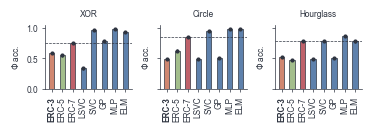

In [9]:
fig, axes = plt.subplots(1,3, figsize=(3.6, 1.2), sharey=True, constrained_layout=True)
for i, (y_task, z_task) in enumerate(zip(y_tasks.values(), z_tasks.values())):
        plot_scores(ax=axes[i], test_scores=test_scores_all[i], test_scores_std=test_scores_std_all[i])
axes[0].set_title('XOR')
axes[1].set_title('Circle')
axes[2].set_title('Hourglass')
plt.savefig(f"../plots/SI_sensor_results_enzyme_size.svg")
plt.show()

# number of inputs

In [19]:
from sklearn import svm, gaussian_process, neural_network, linear_model
from pyrcn.extreme_learning_machine import ELMClassifier
from sklearn import metrics, model_selection
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

classifiers = {
    "LSVC": svm.LinearSVC(max_iter=10_000, tol=1e-4, dual=True),
    "SVC": svm.SVC(max_iter=10_000, tol=1e-4),
    "GP": gaussian_process.GaussianProcessClassifier(),
    "MLP": neural_network.MLPClassifier(max_iter=10_000),
    "ELM": ELMClassifier(regressor=linear_model.Ridge()),
}
N_classifiers = len(classifiers)
classifier_labels = ['ERC'] + list(classifiers.keys())


X = X_7E

feature_sizes = np.arange(11, 102, 1)
trials = 100
n_repeats = 10
N_inputs = U.shape[0] # Number of different inputs

feature_size_val_scores = {k: np.zeros((len(feature_sizes), trials, n_repeats*(N_inputs//5))) for k in y_tasks.keys()}

rng = np.random.default_rng()


for i, (k, y_task) in enumerate(y_tasks.items()):
    for j, feature_size in enumerate(feature_sizes):
        for t in range(trials):
            X_sample = rng.choice(X, size=feature_size, axis=1, replace=False)
            reg = svm.LinearSVC(max_iter=10_000, C=1, tol=1e-4, dual=True)
            scores = model_selection.cross_validate(
                reg, X_sample, y_task(U),
                scoring = metrics.make_scorer(metrics.matthews_corrcoef),
                cv = model_selection.RepeatedStratifiedKFold(
                    n_splits=N_inputs//5, n_repeats=n_repeats,
                ),
                n_jobs=10,
            )
            feature_size_val_scores[k][j,t] = scores['test_score']
        
feature_size_val_scores_mean = {k: np.array([(i.mean()+1)/2 for i in feature_size_val_scores[k]]) for k, i in feature_size_val_scores.items()}
feature_size_val_scores_std = {k: np.array([((i+1)/2).std()/np.sqrt(i.size) for i in feature_size_val_scores[k]]) for k, i in feature_size_val_scores.items()}


In [20]:
feature_size_val_scores_std = {k: np.array([((i+1)/2).std(axis=1)/np.sqrt(i.shape[1]) for i in feature_size_val_scores[k]]).mean(axis=1) for k, i in feature_size_val_scores.items()}

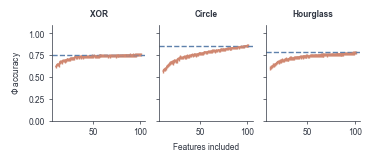

In [21]:
titledict = {'fontweight': 'bold'}

fig, axes = plt.subplots(1,3, figsize=(3.6, 1.5), constrained_layout=True, sharex=True, sharey=True)


for i, (k, v) in enumerate(y_tasks.items()):
    axes[i].set_title(k, fontdict=titledict)
    axes[i].plot(feature_sizes, feature_size_val_scores_mean[k], color='C8')
    axes[i].errorbar(feature_sizes, feature_size_val_scores_mean[k], yerr=feature_size_val_scores_std[k], color='C8')
    axes[i].axhline(test_scores_all[i]['ERC-7'], ls='dashed', color='C0')
    axes[i].set_ylim(0, 1.1)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=1, label='Line'),
                   Line2D([0], [0], color='C8', lw=1, label='Line')]
                   
axes[1].set_xlabel("Features included")
axes[0].set_ylabel((r"$\Phi$ accuracy"))
sns.despine()
plt.savefig(f"../plots/SI_sensor_results_features_size.svg")
